In [ ]:
#!pip install pandas
#!pip install --upgrade --force-reinstall matplotlib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#data3=pd.read_csv("C:/Users/CSE IIT BHILAI/Desktop/RishavKumar(M24DS012)/updated_diseases_dataset.csv")
data3=pd.read_csv("/content/drive/MyDrive/updated_diseases_dataset.csv")
data3.head(1)

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness,prescription,medicine
0,abdominal aortic aneurysm,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"Beta-blockers, Surgery if needed","Propranolol, Atenolol"


In [ ]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Columns: 380 entries, diseases to medicine
dtypes: int64(377), object(3)
memory usage: 2.2+ MB


In [ ]:
medicine_counts = data3['medicine'].value_counts()

# Display frequency count in the required format
#for medicine, count in medicine_counts.items():
 #   print(f"{medicine} = {count}")

In [ ]:
#!pip install pandas networkx pyvis
#!pip install rdflib
#!pip install pandas networkx pyvis
#!pip install spacy

In [ ]:
disease_symptoms = {}

def extract_symptoms(row):
    return [col for col in data3.columns[1:-3] if row[col] == 1]

data3["symptom_list"] = data3.apply(extract_symptoms, axis=1)

data3["medicine"] = data3["medicine"].apply(lambda x: [med.strip() for med in x.split(",")] if isinstance(x, str) else x)


data4=data3[["diseases","prescription","medicine","symptom_list"]]
data4.head()


,diseases,prescription,medicine,symptom_list
0,abdominal aortic aneurysm,"Beta-blockers, Surgery if needed","[Propranolol, Atenolol]","[shortness of breath, palpitations, sharp abdo..."
1,abdominal hernia,"Surgery, Pain management","[Ibuprofen, Acetaminophen]","[groin mass, symptoms of the scrotum and teste..."
2,abscess of nose,"Antibiotics, Incision and drainage","[Amoxicillin, Clindamycin]","[sore throat, cough, nasal congestion, irritab..."
3,abscess of the lung,"Antibiotics, Drainage of abscess","[Piperacillin, Tazobactam]","[shortness of breath, depressive or psychotic ..."
4,abscess of the pharynx,"Antibiotics, Surgical drainage","[Amoxicillin-Clavulanate, Ceftriaxone]","[sharp chest pain, sore throat, cough, nasal c..."


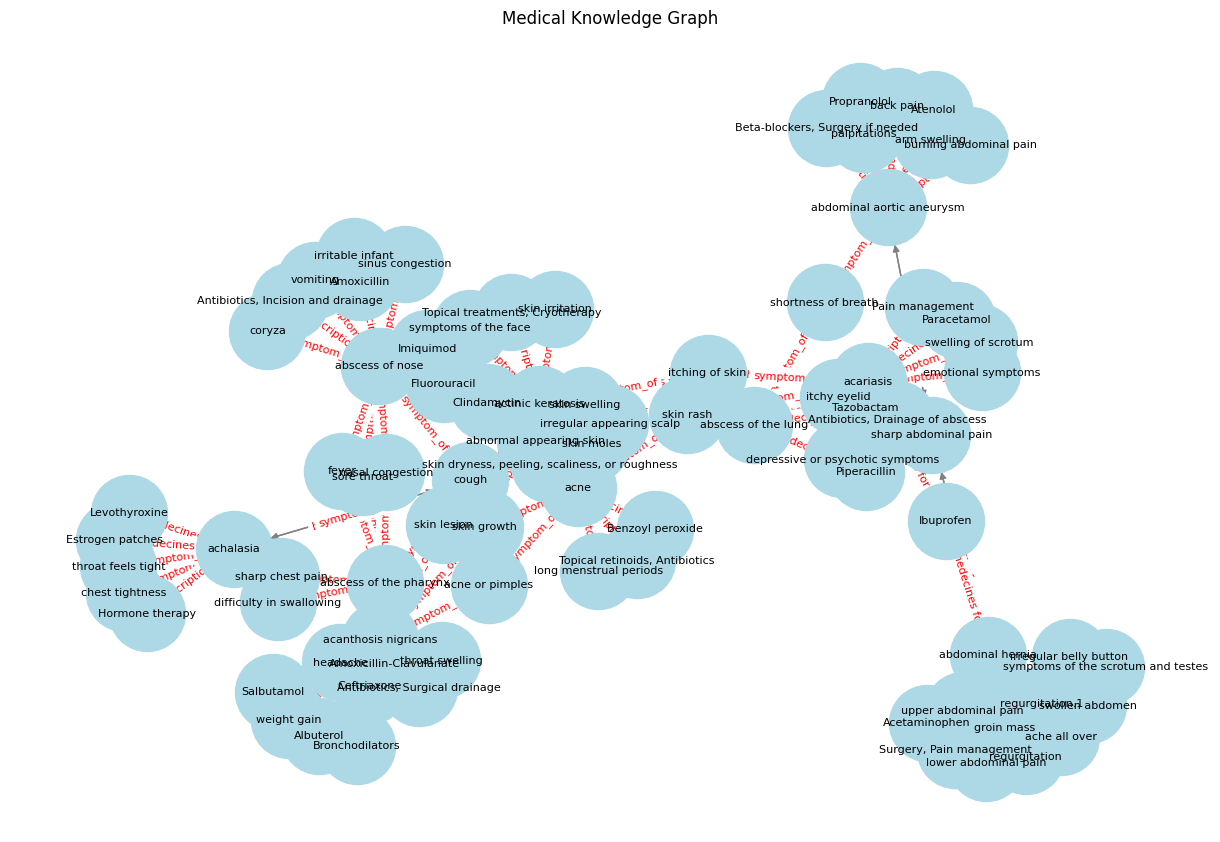

In [ ]:

import networkx as nx

# Convert to DataFrame
df = data3.head(10)

# Create a directed graph
G = nx.DiGraph()
edge_labels={}

# Add nodes and edges
for _, row in df.iterrows():
    disease = row["diseases"]
    G.add_node(disease, type="disease")  # Add disease node

    # Add symptom nodes and edges
    for symptom in row["symptom_list"]:
        G.add_node(symptom, type="symptom")
        G.add_edge(disease, symptom, relation="has_symptom")
        edge_labels[(disease, symptom)] = "has_symptoms"

        G.add_edge(symptom, disease, relation="symptom_of")
        edge_labels[(symptom, disease)] = "symptom_of"

    # Add prescription node
    prescription = row["prescription"]
    G.add_node(prescription, type="prescription")
    G.add_edge(disease, prescription, relation="treated_with")
    edge_labels[(disease, prescription)] = "treated_with"

    G.add_edge(prescription, disease, relation="prescription of")
    edge_labels[(prescription, disease)] = "prescription of"

    # Add medicine nodes and edges
    #medicines = row["medicine"].split(", ")
    for med in row["medicine"]:
        G.add_node(med, type="medicine")
        G.add_edge(disease, med, relation="prescribed_medicine")
        edge_labels[(disease, med)] = "prescribed medecines"

        G.add_edge(med, disease, relation="medicine for")
        edge_labels[(med, disease)] = "medecines for"

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=8, edge_color="gray")

# Draw edge labels (relation names)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=8)

# Show the graph
plt.title("Medical Knowledge Graph")
plt.show()




In [ ]:
#pip install --upgrade pip setuptools wheel
#!pip install nltk
#!pip install flair
#!pip install textblob
#!pip install numpy==1.24.0
#!pip install cython
import spacy

# Check the spaCy version
print(spacy.__version__)

3.8.5


In [ ]:
import networkx as nx
import torch
from difflib import get_close_matches
from textblob import TextBlob

def correct_spelling(text):
    """
    Corrects spelling mistakes in the query using TextBlob.
    """
    return str(TextBlob(text).correct())

def extract_query_entities_and_relations(query: str, kg: nx.Graph):
    query = correct_spelling(query)
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(query)

    predefined_relations = {"has_symptom", "treated_with", "prescription of", "medicines for", "symptom_of"}

    # Extract named entities and noun chunks as candidate entities
    candidate_entities = set(ent.text for ent in doc.ents) | set(chunk.text for chunk in doc.noun_chunks)

    print("Candidate Entities Before Matching:", candidate_entities)  # Debugging line

    # Ensure case-insensitive entity matching
    kg_nodes_lower = {node.lower(): node for node in kg.nodes}  # Map lowercase to original node names
    matched_entities = [kg_nodes_lower[entity.lower()] for entity in candidate_entities if entity.lower() in kg_nodes_lower]

    if not matched_entities:
        for entity in candidate_entities:
            close_matches = get_close_matches(entity.lower(), kg_nodes_lower.keys(), n=1, cutoff=0.6)
            matched_entities.extend([kg_nodes_lower[match] for match in close_matches])

    # Extract potential relations (verbs & prepositions)
    candidate_relations = set(token.lemma_ for token in doc if token.pos_ in ["VERB", "ADP"])

    # Ensure predefined relations are always included if present in the query
    for relation in predefined_relations:
        if relation in query:
            candidate_relations.add(relation)

    # Extract relations from the KG (Find All Close Matches)
    matched_relations = set()
    kg_relations = [data["relation"] for _, _, data in kg.edges(data=True) if "relation" in data]

    for rel in candidate_relations:
        close_matches = get_close_matches(rel, kg_relations, n=1, cutoff=0.6)  # Get multiple matches
        matched_relations.update(close_matches)  # Add all similar relations

    return matched_entities, list(matched_relations)


In [ ]:
import networkx as nx

def retrieve_subgraph(kg: nx.Graph, query_entities: list, query_relations: list, hops: int = 2):
    subgraph_nodes = set()
    subgraph_edges = []

    # Expand from query entities up to 'hops' levels
    for entity in query_entities:
        if entity in kg:
            # Get all nodes within 'hops' distance from the query entity
            neighbors = nx.single_source_shortest_path_length(kg, entity, cutoff=hops)
            subgraph_nodes.update(neighbors.keys())

    # If query relations are provided, filter edges based on the relations
    if query_relations:
        for u, v, data in kg.edges(data=True):
            if u in subgraph_nodes and v in subgraph_nodes:
                if "relation" in data and data["relation"] in query_relations:
                    subgraph_edges.append((u, v, data))
    else:
        # If no query relations are provided, include all edges between the retrieved nodes
        for u in subgraph_nodes:
            neighbors = list(kg.neighbors(u))  # Convert iterator to a list
            #print(u, neighbors)
            for v in neighbors:
                #if v in subgraph_nodes:  # Ensure both nodes exist in the subgraph
                    edge_data = kg.get_edge_data(u, v, default={})
                    #print(edge_data)
                    subgraph_edges.append((u, v, edge_data))

    # Create the final subgraph with filtered nodes and edges
    subgraph = nx.Graph()
    subgraph.add_nodes_from(subgraph_nodes)
    subgraph.add_edges_from(subgraph_edges)

    return subgraph

In [ ]:
query = "I haave back paiin,abscess of the pharynx and hedache what do i do has_symptom sore throat,  cough, nasal congestion"
entities, relations = extract_query_entities_and_relations(query, G)
subgraph = retrieve_subgraph(G, entities, relations, hops=2)

print("Extracted Entities:", entities)
print("Extracted Relations:", relations)
print("Subgraph Nodes:", subgraph.nodes)
print("Subgraph Edges:", subgraph.edges)

Candidate Entities Before Matching: {'back pain', 'i', 'sore throat', 'I', 'cough', 'what', 'nasal congestion', 'the pharynx'}
Extracted Entities: ['back pain', 'sore throat', 'cough', 'nasal congestion']
Extracted Relations: ['has_symptom']
Subgraph Nodes: ['Beta-blockers, Surgery if needed', 'abdominal aortic aneurysm', 'Amoxicillin-Clavulanate', 'Ceftriaxone', 'Tazobactam', 'Clindamycin', 'vomiting', 'depressive or psychotic symptoms', 'fever', 'sharp abdominal pain', 'headache', 'back pain', 'cough', 'sinus congestion', 'coryza', 'difficulty in swallowing', 'achalasia', 'Piperacillin', 'nasal congestion', 'Atenolol', 'throat swelling', 'irritable infant', 'Antibiotics, Incision and drainage', 'chest tightness', 'arm swelling', 'abscess of the lung', 'Antibiotics, Drainage of abscess', 'Amoxicillin', 'itchy eyelid', 'Antibiotics, Surgical drainage', 'Estrogen patches', 'abscess of the pharynx', 'shortness of breath', 'Hormone therapy', 'Levothyroxine', 'burning abdominal pain', 'sor

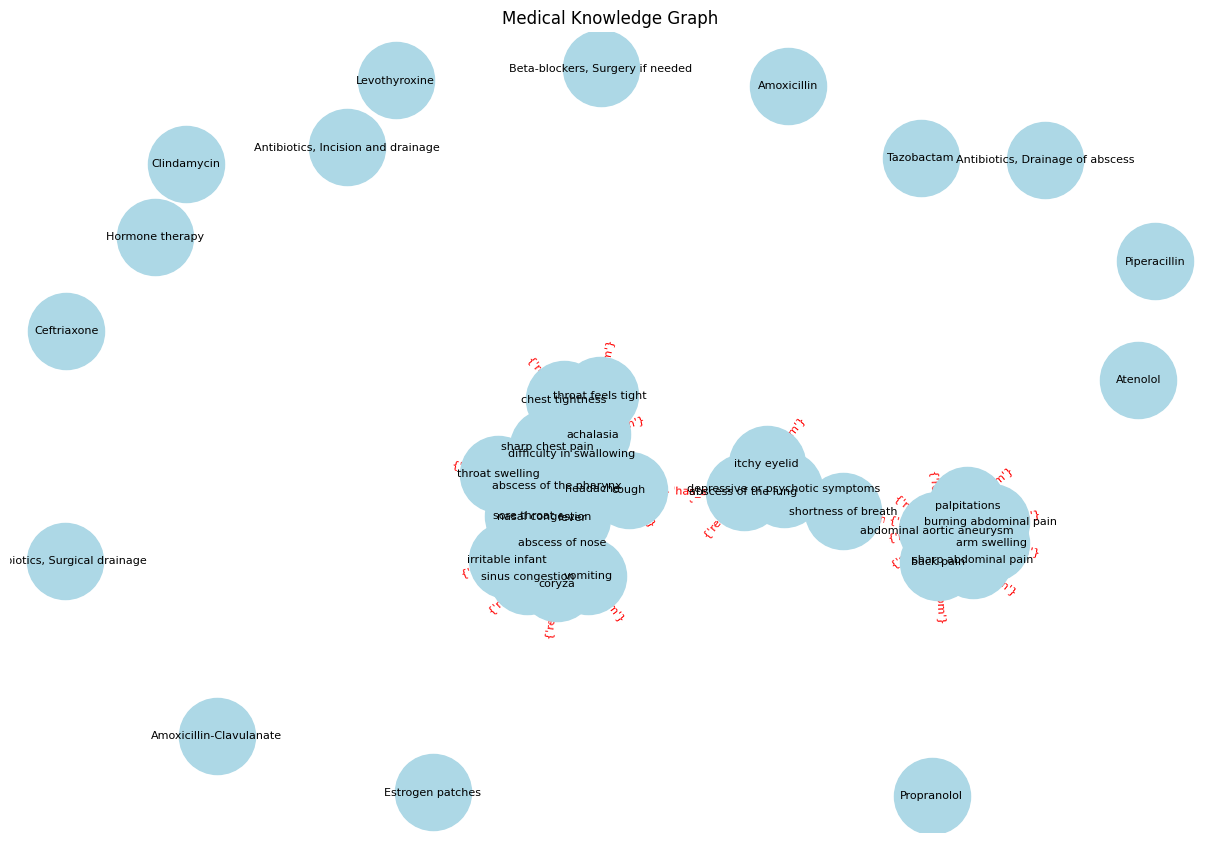

In [ ]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Positioning of nodes
nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=8, edge_color="gray")

# Draw edge labels (relation names)
nx.draw_networkx_edge_labels(subgraph, pos, font_color="red", font_size=8)

# Show the graph
plt.title("Medical Knowledge Graph")
plt.show()

In [ ]:
import spacy
import torch
import networkx as nx
from textblob import TextBlob
from difflib import get_close_matches

class QueryGraphExtractor(torch.nn.Module):
    def __init__(self, kg: nx.Graph, predefined_relations=None, hops: int = 2):
        super().__init__()
        self.kg = kg
        self.hops = hops
        self.predefined_relations = predefined_relations or {"has_symptom", "treated_with", "prescription of", "medicines for", "symptom_of"}
        self.nlp = spacy.load("en_core_web_sm")

        # Preprocess KG nodes for case-insensitive matching
        self.kg_nodes_lower = {node.lower(): node for node in self.kg.nodes}

    def correct_spelling(self, text: str):
        return str(TextBlob(text).correct())

    def extract_entities_relations(self, query: str):
        query = self.correct_spelling(query)
        doc = self.nlp(query)

        candidate_entities = set(ent.text for ent in doc.ents) | set(chunk.text for chunk in doc.noun_chunks)

        matched_entities = [
            self.kg_nodes_lower[entity.lower()] for entity in candidate_entities
            if entity.lower() in self.kg_nodes_lower
        ]

        if not matched_entities:
            for entity in candidate_entities:
                close_matches = get_close_matches(entity.lower(), self.kg_nodes_lower.keys(), n=1, cutoff=0.6)
                matched_entities.extend([self.kg_nodes_lower[match] for match in close_matches])

        candidate_relations = set(token.lemma_ for token in doc if token.pos_ in ["VERB", "ADP"])
        for relation in self.predefined_relations:
            if relation in query:
                candidate_relations.add(relation)

        matched_relations = set()
        kg_relations = [data["relation"] for _, _, data in self.kg.edges(data=True) if "relation" in data]
        for rel in candidate_relations:
            close_matches = get_close_matches(rel, kg_relations, n=1, cutoff=0.6)
            matched_relations.update(close_matches)

        return matched_entities, list(matched_relations)

    def retrieve_subgraph(self, entities: list, relations: list):
        subgraph_nodes = set()
        subgraph_edges = []

        for entity in entities:
            if entity in self.kg:
                neighbors = nx.single_source_shortest_path_length(self.kg, entity, cutoff=self.hops)
                subgraph_nodes.update(neighbors.keys())

        if relations:
            for u, v, data in self.kg.edges(data=True):
                if u in subgraph_nodes and v in subgraph_nodes:
                    if "relation" in data and data["relation"] in relations:
                        subgraph_edges.append((u, v, data))
        else:
            for u in subgraph_nodes:
                for v in self.kg.neighbors(u):
                    edge_data = self.kg.get_edge_data(u, v, default={})
                    subgraph_edges.append((u, v, edge_data))

        subgraph = nx.Graph()
        subgraph.add_nodes_from(subgraph_nodes)
        subgraph.add_edges_from(subgraph_edges)
        return subgraph

    def forward(self, query: str):
        entities, relations = self.extract_entities_relations(query)
        subgraph = self.retrieve_subgraph(entities, relations)
        return subgraph, entities, relations


In [ ]:
kg_extractor = QueryGraphExtractor(kg=G)  # Pass your knowledge graph `G`

query = "I haave back paiin,abscess of the pharynx and hedache what do i do has_symptom sore throat,  cough, nasal congestion"
subgraph, entities, relations = kg_extractor(query)

print("Entities:", entities)
print("Relations:", relations)
print("Subgraph:", subgraph.nodes, subgraph.edges)


Entities: ['cough', 'nasal congestion', 'sore throat', 'back pain']
Relations: ['has_symptom']
Subgraph: ['abscess of the pharynx', 'sharp chest pain', 'depressive or psychotic symptoms', 'Antibiotics, Incision and drainage', 'shortness of breath', 'Levothyroxine', 'Ceftriaxone', 'abdominal aortic aneurysm', 'Hormone therapy', 'Antibiotics, Drainage of abscess', 'itchy eyelid', 'chest tightness', 'vomiting', 'Propranolol', 'sore throat', 'irritable infant', 'Atenolol', 'fever', 'Amoxicillin', 'Amoxicillin-Clavulanate', 'Beta-blockers, Surgery if needed', 'difficulty in swallowing', 'Estrogen patches', 'nasal congestion', 'sinus congestion', 'headache', 'Tazobactam', 'coryza', 'Piperacillin', 'abscess of the lung', 'Clindamycin', 'throat feels tight', 'burning abdominal pain', 'cough', 'throat swelling', 'back pain', 'sharp abdominal pain', 'arm swelling', 'Antibiotics, Surgical drainage', 'achalasia', 'palpitations', 'abscess of nose'] [('abscess of the pharynx', 'sharp chest pain'), (

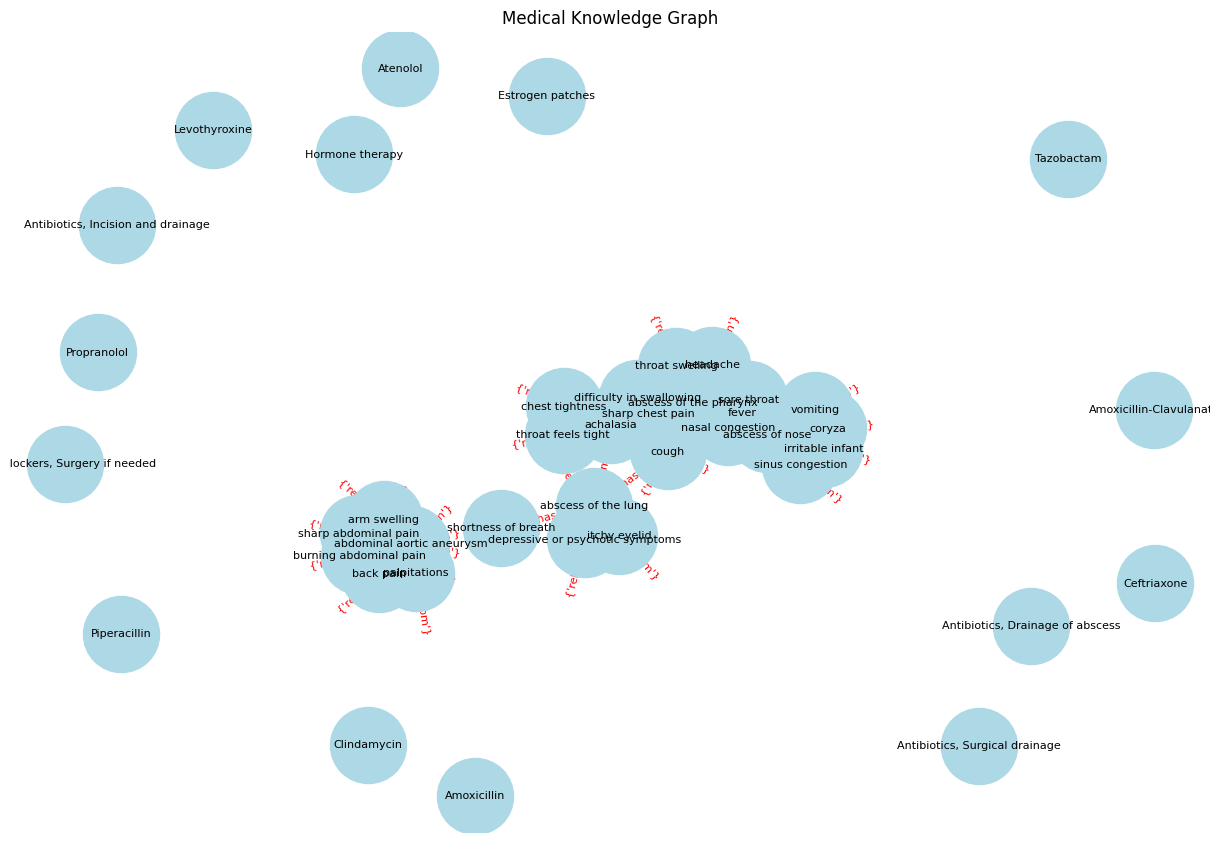

In [ ]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Positioning of nodes
nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=8, edge_color="gray")

# Draw edge labels (relation names)
nx.draw_networkx_edge_labels(subgraph, pos, font_color="red", font_size=8)

# Show the graph
plt.title("Medical Knowledge Graph")
plt.show()

In [ ]:
def preprocess_full_graph(full_graph: nx.DiGraph):
    node_mapping = {node: i for i, node in enumerate(full_graph.nodes)}
    return node_mapping

In [ ]:
global_mapping = preprocess_full_graph(G)


In [ ]:
def contrastive_loss(embeddings, edge_index, margin=1.0):
    pos_pairs = embeddings[edge_index[0]] - embeddings[edge_index[1]]  # Differences for connected nodes
    pos_loss = torch.mean(torch.norm(pos_pairs, dim=1) ** 2)  # L2 loss for positive pairs

    # Negative sampling: Select random unconnected nodes
    neg_idx = torch.randint(0, embeddings.shape[0], (edge_index.shape[1],))
    neg_pairs = embeddings[edge_index[0]] - embeddings[neg_idx]
    neg_loss = torch.mean(torch.clamp(margin - torch.norm(neg_pairs, dim=1), min=0) ** 2)  # Hinge loss for negatives

    return pos_loss + neg_loss


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install torch torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNNClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, global_mapping=None,device='cuda'):
        super(GNNClassifier, self).__init__()
        self.device = device
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)  # Output matches number of classes
        self.to(self.device)

    @staticmethod
    def convert_nx_to_torch_data(subgraph: nx.DiGraph, global_node_mapping: dict, labels_dict=None, num_classes=3):
        for node in subgraph.nodes:
            if node not in global_node_mapping:
                global_node_mapping[node] = len(global_node_mapping)

        total_nodes = len(global_node_mapping)
        edge_index = torch.tensor(
            [[global_node_mapping[u], global_node_mapping[v]] for u, v in subgraph.edges], dtype=torch.long
        ).t().contiguous()

        x = torch.zeros((total_nodes, total_nodes))
        for node in subgraph.nodes:
           idx = global_node_mapping[node]
           x[idx, idx] = 1.0  # One-hot encoding at the diagonal

        if labels_dict:
           y = torch.zeros(total_nodes, dtype=torch.long)
           for node in subgraph.nodes:
              y[global_node_mapping[node]] = labels_dict.get(node, 0)
        else:
           y = torch.randint(0, num_classes, (total_nodes,))

        return Data(x=x, edge_index=edge_index, y=y)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Softmax for classification


In [ ]:
graph_data = GNNClassifier.convert_nx_to_torch_data(G, global_mapping)

In [ ]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 64  # Adjust based on your dataset
encoder = GNNClassifier(in_channels=graph_data.num_node_features, hidden_channels=16, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)

# Move data to GPU
graph_data = graph_data.to(device)

# Training Loop
def train():
    encoder.train()
    optimizer.zero_grad()

    out = encoder(graph_data.x, graph_data.edge_index)  # Forward pass
    loss = F.cross_entropy(out, graph_data.y)  # Cross-Entropy Loss

    loss.backward()
    optimizer.step()
    return loss.item()

# Train for 100 epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Extract Final Node Embeddings
encoder.eval()
final_embeddings = encoder(graph_data.x, graph_data.edge_index).detach().cpu().numpy()

print("Final Node Embeddings Shape:", final_embeddings.shape)


Epoch 0, Loss: 4.1758
Epoch 10, Loss: 3.7285
Epoch 20, Loss: 2.6560
Epoch 30, Loss: 1.4882
Epoch 40, Loss: 1.0974
Epoch 50, Loss: 1.0136
Epoch 60, Loss: 0.9438
Epoch 70, Loss: 0.8644
Epoch 80, Loss: 0.7748
Epoch 90, Loss: 0.6789
Final Node Embeddings Shape: (85, 64)


In [ ]:
#!pip install torch transformers sentence-transformers

In [ ]:
#!pip install tokenizers==0.15.2
#!pip install --upgrade transformers
#!pip uninstall -y transformers huggingface-hub sentence-transformers tokenizers accelerate datasets
#!pip cache purge
#!pip install transformers huggingface_hub sentence-transformers
#!pip install --upgrade transformers sentence-transformers accelerate datasets


#!pip show transformers huggingface_hub

In [ ]:
#!pip install transformers torch numpy
#!pip install transformers torch
#!pip uninstall transformers -y
#!pip install transformers --no-deps


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import re
from textblob import TextBlob

# Define the model class
class TextEmbeddingModel(nn.Module):
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
        super(TextEmbeddingModel, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.text_encoder = AutoModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

    def purify_query(self,query: str) -> str:
        corrected_query = str(TextBlob(query).correct())
        cleaned_query = re.sub(r"[^a-zA-Z0-9\s]", "", corrected_query)
        cleaned_query = re.sub(r"\s+", " ", cleaned_query).strip()
        return cleaned_query

    def get_text_embedding(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(self.text_encoder.device)
        with torch.no_grad():
            outputs = self.text_encoder(**inputs)

        # Use the [CLS] token embedding as the sentence representation
        return outputs.last_hidden_state[:, 0, :].squeeze(0)

    def forward(self, text):
        text = self.purify_query(query)
        # Use the text embedding function in the forward pass
        return self.get_text_embedding(text)

# Example usage
text_encoder = TextEmbeddingModel().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
embedding = text_encoder(query)
print("Text Embedding Shape:", embedding.shape)

Text Embedding Shape: torch.Size([384])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossModalityPooling(nn.Module):
    def __init__(self, graph_dim, text_dim, common_dim=128):
        super(CrossModalityPooling, self).__init__()
        self.graph_proj = nn.Linear(graph_dim, common_dim)
        self.text_proj = nn.Linear(text_dim, common_dim)

    def forward(self, graph_embeddings, text_embedding):
        """
        graph_embeddings: Tensor of shape [N, graph_dim] (e.g., [100, 64])
        text_embedding: Tensor of shape [text_dim] (e.g., [384])
        """
        # Project both modalities to a common space
        graph_proj = self.graph_proj(graph_embeddings)                # → [N, common_dim]
        text_proj = self.text_proj(text_embedding).unsqueeze(0)       # → [1, common_dim]

        # Attention: dot-product (scaled)
        attn_scores = torch.softmax(torch.matmul(graph_proj, text_proj.T) / (graph_proj.shape[-1] ** 0.5), dim=0)  # [N, 1]

        # Apply attention over graph embeddings
        pooled = (attn_scores * graph_proj).sum(dim=0)  # → [common_dim]

        return pooled  # Final fused representation


In [ ]:
class DomainProjector(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )

    def forward(self, x):
        return self.ffn(x)


In [ ]:
class LinkPrediction(nn.Module):
    def __init__(self, embedding_dim):
        super(LinkPrediction, self).__init__()
        self.linear = nn.Linear(embedding_dim * 2, 1)

    def forward(self, head_embedding, tail_embedding):
        # Concatenate head and tail embeddings
        x = torch.cat([head_embedding, tail_embedding], dim=-1)
        return self.linear(x)


In [ ]:
#!pip install peft

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import PeftModel, get_peft_model, LoraConfig

In [ ]:
class GNPModel(nn.Module):
    def __init__(self,KG, gnn_encoder,text_encoder, cross_modal_pooling, base_model_id="google/flan-t5-base", lora_path=None):
        super(GNPModel, self).__init__()
        self.global_mapping = {}
        self.kg_extractor=QueryGraphExtractor(kg=KG)
        self.gnn_encoder = gnn_encoder
        self.text_encoder = text_encoder
        self.cross_modal_pooling = cross_modal_pooling

        self.tokenizer = AutoTokenizer.from_pretrained(base_model_id)
        base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_id, device_map="auto", load_in_8bit=True)

        if lora_path:
            self.llm = PeftModel.from_pretrained(base_model, lora_path)
        else:
            lora_config = LoraConfig(task_type="SEQ_2_SEQ_LM", r=8, lora_alpha=32, lora_dropout=0.1)
            self.llm = get_peft_model(base_model, lora_config)

    def forward(self, query):
        subgraph, entities, relations = self.kg_extractor(query)
        if subgraph.number_of_nodes() == 0 or subgraph.number_of_edges() == 0:
          return "⚠️ No relevant knowledge found in the graph for this query."
        graph_data=self.gnn_encoder.convert_nx_to_torch_data(subgraph,self.global_mapping).to(device)
        if graph_data.edge_index.size(1) == 0:
          return "⚠️ Empty edge_index after conversion, cannot process GNN."
        gnn_output = self.gnn_encoder(graph_data.x, graph_data.edge_index).to(device)
        text_embedding=self.text_encoder(query).to(device)

        pooled_representation = self.cross_modal_pooling(gnn_output, text_embedding).to(device)
        prompt = f"{pooled_representation}\n{query}"

        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(self.llm.device)
        outputs = self.llm.generate(**inputs, max_new_tokens=64)
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
def generate_answer(query, max_len=50):
    model.eval()
    with torch.no_grad():
        output = model(query).to(device)
    return output

# Run for all test queries
for query in test_queries:
    output = generate_answer(query)
    print(f"🧠 Query: {query}\n🗣️  Answer: {output}\n{'-'*60}")

NameError: name 'model' is not defined

In [ ]:
graph_data=encoder.convert_nx_to_torch_data(subgraph,global_mapping).to(device)
gnn_output = encoder(graph_data.x.to(device), graph_data.edge_index)
gnn_output.shape,embedding.shape

(torch.Size([85, 64]), torch.Size([384]))

In [ ]:
kg_extractor = QueryGraphExtractor(kg=G)
gnn_encoder = encoder
cross_modal_pooling = CrossModalityPooling(graph_dim=64, text_dim=384, common_dim=128)

# Initialize the GNP model
model = GNPModel(
    KG=G,
    gnn_encoder=gnn_encoder,
    text_encoder=text_encoder,
    cross_modal_pooling=cross_modal_pooling
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

In [ ]:
#!pip install  bitsandbytes

In [ ]:
import json

def load_jsonl_dataset(path):
    data = []
    with open(path, "r") as f:
        for line in f:
            example = json.loads(line.strip())
            data.append(example)
    return data

# Example usage
dataset = load_jsonl_dataset("C:/Users/CSE IIT BHILAI/Desktop/RishavKumar(M24DS012)/disease_query_answer_pairs.jsonl")

# Peek at some samples
for item in dataset[:3]:
    print(item)


{'query': 'What are the symptoms of abdominal aortic aneurysm?', 'answer': 'shortness of breath, palpitations, sharp abdominal pain, arm swelling, back pain, burning abdominal pain'}
{'query': 'Which medicines are prescribed for abdominal aortic aneurysm?', 'answer': 'Propranolol, Atenolol'}
{'query': 'What is the treatment for abdominal aortic aneurysm?', 'answer': 'Beta-blockers, Surgery if needed'}


In [ ]:
from torch.utils.data import Dataset

class GNPQueryDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        query = item["query"]
        answer = item["answer"]

        input_enc = self.tokenizer(query, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        target_enc = self.tokenizer(answer, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")

        input_ids = input_enc["input_ids"].squeeze()
        attention_mask = input_enc["attention_mask"].squeeze()
        labels = target_enc["input_ids"].squeeze()

        # Replace padding token id's of the labels by -100 so they are ignored by the loss
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }


In [ ]:
tokenizer = model.tokenizer  # Use tokenizer from your GNPModel
train_dataset = GNPQueryDataset(dataset, tokenizer)

In [ ]:
from torch.utils.data import DataLoader

# Parameters
batch_size = 4  # You can increase this if you have enough GPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import os
best_loss = float('inf')
save_path = "best_model.pt"
patience = 5
counter = 0
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

train_losses = []

for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    epoch_loss = 0

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model.llm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"✅ Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

     # ✅ Checkpoint saving
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), save_path)
        print(f"🎯 New best model saved at Epoch {epoch+1} with loss {avg_loss:.4f}")
        counter = 0
    else:
        counter += 1
        print(f"📉 No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print("🛑 Early stopping triggered.")
            break


Epoch 1/25: 100%|█████████████████████████████████████████████████████████| 580/580 [02:50<00:00,  3.40it/s, loss=3.53]


✅ Epoch 1 Average Loss: 3.4794
🎯 New best model saved at Epoch 1 with loss 3.4794


Epoch 2/25: 100%|█████████████████████████████████████████████████████████| 580/580 [02:46<00:00,  3.48it/s, loss=2.47]


✅ Epoch 2 Average Loss: 3.1238
🎯 New best model saved at Epoch 2 with loss 3.1238


Epoch 3/25: 100%|█████████████████████████████████████████████████████████| 580/580 [02:48<00:00,  3.44it/s, loss=1.85]


✅ Epoch 3 Average Loss: 2.7241
🎯 New best model saved at Epoch 3 with loss 2.7241


Epoch 4/25: 100%|██████████████████████████████████████████████████████████| 580/580 [02:49<00:00,  3.42it/s, loss=2.2]


✅ Epoch 4 Average Loss: 2.4353
🎯 New best model saved at Epoch 4 with loss 2.4353


Epoch 5/25: 100%|█████████████████████████████████████████████████████████| 580/580 [02:47<00:00,  3.46it/s, loss=2.21]


✅ Epoch 5 Average Loss: 2.2400
🎯 New best model saved at Epoch 5 with loss 2.2400


Epoch 6/25: 100%|█████████████████████████████████████████████████████████| 580/580 [02:39<00:00,  3.64it/s, loss=1.49]


✅ Epoch 6 Average Loss: 2.0930
🎯 New best model saved at Epoch 6 with loss 2.0930


Epoch 7/25: 100%|█████████████████████████████████████████████████████████| 580/580 [02:40<00:00,  3.62it/s, loss=2.41]


✅ Epoch 7 Average Loss: 1.9840
🎯 New best model saved at Epoch 7 with loss 1.9840


Epoch 8/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:39<00:00,  3.64it/s, loss=0.583]


✅ Epoch 8 Average Loss: 1.9032
🎯 New best model saved at Epoch 8 with loss 1.9032


Epoch 9/25: 100%|██████████████████████████████████████████████████████████| 580/580 [02:38<00:00,  3.65it/s, loss=2.8]


✅ Epoch 9 Average Loss: 1.8482
🎯 New best model saved at Epoch 9 with loss 1.8482


Epoch 10/25: 100%|███████████████████████████████████████████████████████| 580/580 [02:43<00:00,  3.55it/s, loss=0.626]


✅ Epoch 10 Average Loss: 1.7854
🎯 New best model saved at Epoch 10 with loss 1.7854


Epoch 11/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:35<00:00,  3.74it/s, loss=1.55]


✅ Epoch 11 Average Loss: 1.7406
🎯 New best model saved at Epoch 11 with loss 1.7406


Epoch 12/25: 100%|███████████████████████████████████████████████████████| 580/580 [02:43<00:00,  3.55it/s, loss=0.428]


✅ Epoch 12 Average Loss: 1.7299
🎯 New best model saved at Epoch 12 with loss 1.7299


Epoch 13/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:37<00:00,  3.68it/s, loss=1.65]


✅ Epoch 13 Average Loss: 1.6902
🎯 New best model saved at Epoch 13 with loss 1.6902


Epoch 14/25: 100%|███████████████████████████████████████████████████████| 580/580 [02:40<00:00,  3.61it/s, loss=0.793]


✅ Epoch 14 Average Loss: 1.6632
🎯 New best model saved at Epoch 14 with loss 1.6632


Epoch 15/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:42<00:00,  3.57it/s, loss=1.86]


✅ Epoch 15 Average Loss: 1.6414
🎯 New best model saved at Epoch 15 with loss 1.6414


Epoch 16/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:42<00:00,  3.56it/s, loss=1.67]


✅ Epoch 16 Average Loss: 1.6114
🎯 New best model saved at Epoch 16 with loss 1.6114


Epoch 17/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:40<00:00,  3.61it/s, loss=2.17]


✅ Epoch 17 Average Loss: 1.6003
🎯 New best model saved at Epoch 17 with loss 1.6003


Epoch 18/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:42<00:00,  3.57it/s, loss=2.08]


✅ Epoch 18 Average Loss: 1.5971
🎯 New best model saved at Epoch 18 with loss 1.5971


Epoch 19/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:42<00:00,  3.57it/s, loss=1.84]


✅ Epoch 19 Average Loss: 1.5784
🎯 New best model saved at Epoch 19 with loss 1.5784


Epoch 20/25: 100%|███████████████████████████████████████████████████████| 580/580 [02:40<00:00,  3.60it/s, loss=0.556]


✅ Epoch 20 Average Loss: 1.5663
🎯 New best model saved at Epoch 20 with loss 1.5663


Epoch 21/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:42<00:00,  3.57it/s, loss=1.84]


✅ Epoch 21 Average Loss: 1.5703
📉 No improvement. Patience counter: 1/5


Epoch 22/25: 100%|█████████████████████████████████████████████████████████| 580/580 [02:45<00:00,  3.50it/s, loss=1.1]


✅ Epoch 22 Average Loss: 1.5398
🎯 New best model saved at Epoch 22 with loss 1.5398


Epoch 23/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:41<00:00,  3.58it/s, loss=1.51]


✅ Epoch 23 Average Loss: 1.5357
🎯 New best model saved at Epoch 23 with loss 1.5357


Epoch 24/25: 100%|███████████████████████████████████████████████████████| 580/580 [02:39<00:00,  3.63it/s, loss=0.551]


✅ Epoch 24 Average Loss: 1.5362
📉 No improvement. Patience counter: 1/5


Epoch 25/25: 100%|████████████████████████████████████████████████████████| 580/580 [02:41<00:00,  3.59it/s, loss=1.51]

✅ Epoch 25 Average Loss: 1.5451
📉 No improvement. Patience counter: 2/5


In [ ]:
torch.save(model, "gnp_model_full1.pth")

In [ ]:
gnn_encoder = encoder
cross_modal_pooling = CrossModalityPooling(graph_dim=64, text_dim=384, common_dim=128)

cross_modal_pooling(gnn_output, embedding)

tensor([  1.3731,   1.3695,  -3.1768,  -2.3471,   2.1886,   4.1441,   2.2795,
         -9.4333,   7.0472,   2.8879,   5.2193,  -6.2660,  -2.7473,   1.4386,
          5.9678,   2.9938,  -2.6217,  -6.7149,  -1.3894,  11.3002,   4.7716,
         -7.3941,  10.3214,  -0.2030,  -1.2323,  12.2668,  -0.1125,  15.2097,
         -8.4247,  -3.9203,  -0.3423,  -7.8613,  -3.9411,  11.7107,   5.8192,
          5.9805,   6.7697,   1.5290,   0.1003,  10.2460,   3.6919,  -5.6111,
         -5.8823,  -3.3310,  -6.9257, -10.5645,  -0.8710,  -9.9671,   3.5592,
         10.7809,  16.1394,  12.3934, -10.9164,   1.0353,  -1.2880,   9.1468,
        -13.2454,   0.1749,   7.2134,   3.8656,  -1.9608,  -4.1103,   3.9121,
         12.1148, -12.8553,  16.7420, -14.3880,  -6.7752,   4.0979,   6.4427,
         -4.6146, -14.2509,  -5.0380,   3.6662,  -5.5443,   1.8455,  -9.6124,
         -5.9878,   1.7895,  -3.4060,   6.3179,  -7.3464,   7.5667,   2.5078,
          9.2456, -12.3701,   0.8208,   0.9414,  -1.8434,  -2.41

In [ ]:
#!pip install -U bitsandbytes

In [ ]:
kg_extractor = QueryGraphExtractor(kg=G)
gnn_encoder = encoder
cross_modal_pooling = CrossModalityPooling(graph_dim=64, text_dim=384, common_dim=128)

# Initialize the GNP model
model = GNPModel(
    kg_extractor=kg_extractor,
    gnn_encoder=gnn_encoder,
    text_encoder=text_encoder,
    cross_modal_pooling=cross_modal_pooling
)

In [ ]:
import torch

model1 = torch.load("C:/Users/CSE IIT BHILAI/Downloads/gnp_model_full.pth")
model1 = model1.to(device)
model1.eval()

C:\Users\CSE IIT BHILAI\AppData\Local\Temp\ipykernel_13724\3463558238.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load("C:/Users/CSE IIT BHILAI/Downlo

GNPModel(
  (kg_extractor): QueryGraphExtractor()
  (gnn_encoder): GNNClassifier(
    (conv1): GCNConv(85, 16)
    (conv2): GCNConv(16, 64)
  )
  (text_encoder): TextEmbeddingModel(
    (text_encoder): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 384, padding_idx=0)
        (position_embeddings): Embedding(512, 384)
        (token_type_embeddings): Embedding(2, 384)
        (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-5): 6 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.1, inp

In [ ]:
test_queries = [
    "Which medicines are prescribed for having fever?",
    "What is the treatment for back pain?",
    "What are the symptoms of eustachian tube dysfunction (ear disorder)?"
]


In [ ]:
def generate_answer(query, max_len=50):
    model1.eval()
    with torch.no_grad():
        output = model1(query)
    return output

# Run for all test queries
for query in test_queries:
    output = generate_answer(query)
    print(f"🧠 Query: {query}\n🗣️  Answer: {output}\n{'-'*60}")


KeyError: 'Amoxicillin'